# Western Governors University
## D214 - Data Analytics Capstone
### XGBoost Charity Classifier
### Shane Boyce

## Introduction

## Purpose and Research Questions

The purpose of this project is to create a model that can predict whether an individual will donate to a charity based on their demographic information. With this data, can an XGBoost model predict likely donors with a 70% or higher accuracy?

### Data Collection
This project is a capstone project for the Data Analytics program at Western Governors University. The goal of this project is to create a model that can predict whether an individual will donate to a charity based on their demographic information. The data set used for this project is the "Adult" data set from the UCI Machine Learning Repository. The data set contains 32,561 observations and 14 variables. The data set is a modified version of the "Census Income" data set. The original data set can be found here: https://archive.ics.uci.edu/ml/datasets/Census+Income

Originally, this data was used in a paper by Ron Kohavi and Barry Becker using a Naive Bayes classification. The paper can be found here: https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf. The data has been donated to UCI by the authors under the creative commons license and is available for free download and general purpose use provided that the authors are cited.

The data set contains the following variables which is also included in the data dictionary attached

1. age: continuous.
2. workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
3. fnlwgt: continuous. To be dropped as it is used for weighting in non XGB models.
4. education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
5. education-num: continuous.
6. marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
7. occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
8. relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
9. race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
10. sex: Female, Male.
11. capital-gain: continuous.
12. capital-loss: continuous.
13. hours-per-week: continuous.
14. native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

### Data Extraction and Collection

The data is initially a text file with a .data extension and a .test extension. The data will be programmatically converted to CSV for exploratory data analysis. After exploratory data analysis, the data will be further prepared to be used in a XGBoost model. The details will be in line with the data preparation section below.

### Data Assmptions

The model will be used to identify individuals who are most likely to donate to a charity, and then target them with marketing campaigns. The model will be evaluated based on its accuracy. There is a presumption that individuals making more than $50,000 are more likely to donate to a charity than those making less than $50,000 and therefore charity donators will be defined as those making more than $50,000. While on surface this may seem reasonable, it is possible that individuals making less than $50,000 are more likely to donate to a charity than those making less. The presumption that individuals making more than $50,000 are more likely to donate to a charity also includes the assumption that those making more than the target provide more substantial donations. These two assumptions are why the target is set at $50,000.



## XGBoost Model

According to Josh Starmer, PhD, XGBoost is a machine learning algorithm with many parts (2019). These parts include the following:

1. Gradient Boosting
2. Regularization
3. Unique Regression Tree
4. Weighted Quantile Sketch
5. Sparsity-Aware Split Finding
6. Parallelization
7. Cache-aware Access
8. Out-of-Core Computing


Gradient boosting is a machine learning technique for regression and classification problems. It produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. The method is based on the idea of boosting, which is a sequential technique that attempts to correct the mistakes of the previous model in the sequence. The method is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models to the ensemble (Starmer, 2019).

Regularization in an XGBoost model is the process of applying Ridge Regression and Lasso Regresion to the XGBoost model. Ridge Regression is a technique that adds a penalty to the loss function for large coefficients. Lasso Regression is a technique that adds a penalty to the loss function for large coefficients and can be used to select important features for a model (Starmer, 2019).


XGBoost uses a unique regression tree. This tree is a decision tree that is used to make predictions. The tree is constructed by splitting the training set into two or more homogeneous sets using a single input variable. The tree is constructed in a top-down greedy manner where each split is chosen to maximize a metric. The tree is constructed in a way that minimizes the loss function. This is done many times to build many quick trees to ensemble to maximize the Similarity score. A similarity score is calculated as

(Sum of residuals)<sup>2</sup> / Count of residuals + λ (regularization parameter via ridge or lasso. Defaulting to 1 in XGBoost)

The trees are then evaluated by their gain in the similarity score. The tree with the highest gain is added to the ensemble. The process is repeated until the loss function is minimized. Gain can be calculated as

Gain = Left<sub>similarity</sub> + Right<sub>similarity</sub> - Parent<sub>similarity</sub> 

This can tree can become incredible expansive. XGBoost defaults each tree to 6 levels. 

The branch is then compared to a chosen gamma. If the gain is less than the gamma, the branch is not split. This is a way to prevent overfitting. This starts at the lowest branches so roots are not affected if their gain is greater than the gamma.

The next steps for XGBoost is to call the learning rate (eta) at a default rate of 0.3. A prediction is made with the original prediction plus (eta * decision tree output). This is done until the residuals are can't be improved or the maximum number of trees is reach. Each subsequent decision tree then learns from the residuals of it's predecessor. 

The above process is true for regression and classification with the exception of the loss function. For regression, the loss function is the sum of squared residuals. For classification, the loss function is the log loss function. The log loss function is the negative log likelihood of the true label given a set of scores.

Both categorical and continuous data can be used in XGBoost models. Categorical data is converted to a one-hot encoding. Continuous data is used as is due to decision trees being able to handle continuous data without any preprocessing.


In [1]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split

### Data Preparation

In [2]:
#convert adult.data to dataframe

df = pd.read_csv('adult.data', header=None)

#convert adult.test to validation dataframe

df_validation = pd.read_csv('adult.test', header=None)

In [3]:
#header creation via data dictionary
headers = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

#add headers to dataframes

df.columns = headers
df_validation.columns = headers

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
#verify each dataframe has the same number of columns
df.columns == df_validation.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
#create list of all continuous variables
continuous_variables = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
#create list of all categorical variables
categorical_variables = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race','sex','native-country', 'income']
#target variable
target_variable = 'income'

In [7]:
#describe the dataframes contiuos variables
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education-num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


In [8]:
df_validation.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,16281.0,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
fnlwgt,16281.0,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
education-num,16281.0,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
capital-gain,16281.0,1081.905104,7583.935968,0.0,0.0,0.0,0.0,99999.0
capital-loss,16281.0,87.899269,403.105286,0.0,0.0,0.0,0.0,3770.0
hours-per-week,16281.0,40.392236,12.479332,1.0,40.0,40.0,45.0,99.0


In [9]:
#check for null values
df.isnull().any(), df_validation.isnull().any()

(age               False
 workclass         False
 fnlwgt            False
 education         False
 education-num     False
 marital-status    False
 occupation        False
 relationship      False
 race              False
 sex               False
 capital-gain      False
 capital-loss      False
 hours-per-week    False
 native-country    False
 income            False
 dtype: bool,
 age               False
 workclass         False
 fnlwgt            False
 education         False
 education-num     False
 marital-status    False
 occupation        False
 relationship      False
 race              False
 sex               False
 capital-gain      False
 capital-loss      False
 hours-per-week    False
 native-country    False
 income            False
 dtype: bool)

In [10]:
#check for duplicate values
df.duplicated().sum(), df_validation.duplicated().sum()

(24, 5)

In [11]:
#duplicate rows may be valid but we will drop them for now as they are a small percentage of the data
df.drop_duplicates(inplace=True)
df_validation.drop_duplicates(inplace=True)
df.duplicated().sum(), df_validation.duplicated().sum()

(0, 0)

In [12]:
#verify size of dataframes
df.shape, df_validation.shape

((32537, 15), (16276, 15))

The training data is nearly double the size of the validation data. chosing a smaller sample of training data will reduce time and computational resources of the model and allow a test of the model on the validation data and within its own training data. The training data will be set to 80% size of the validation data but within the main dataframe, or about 13000 rows.

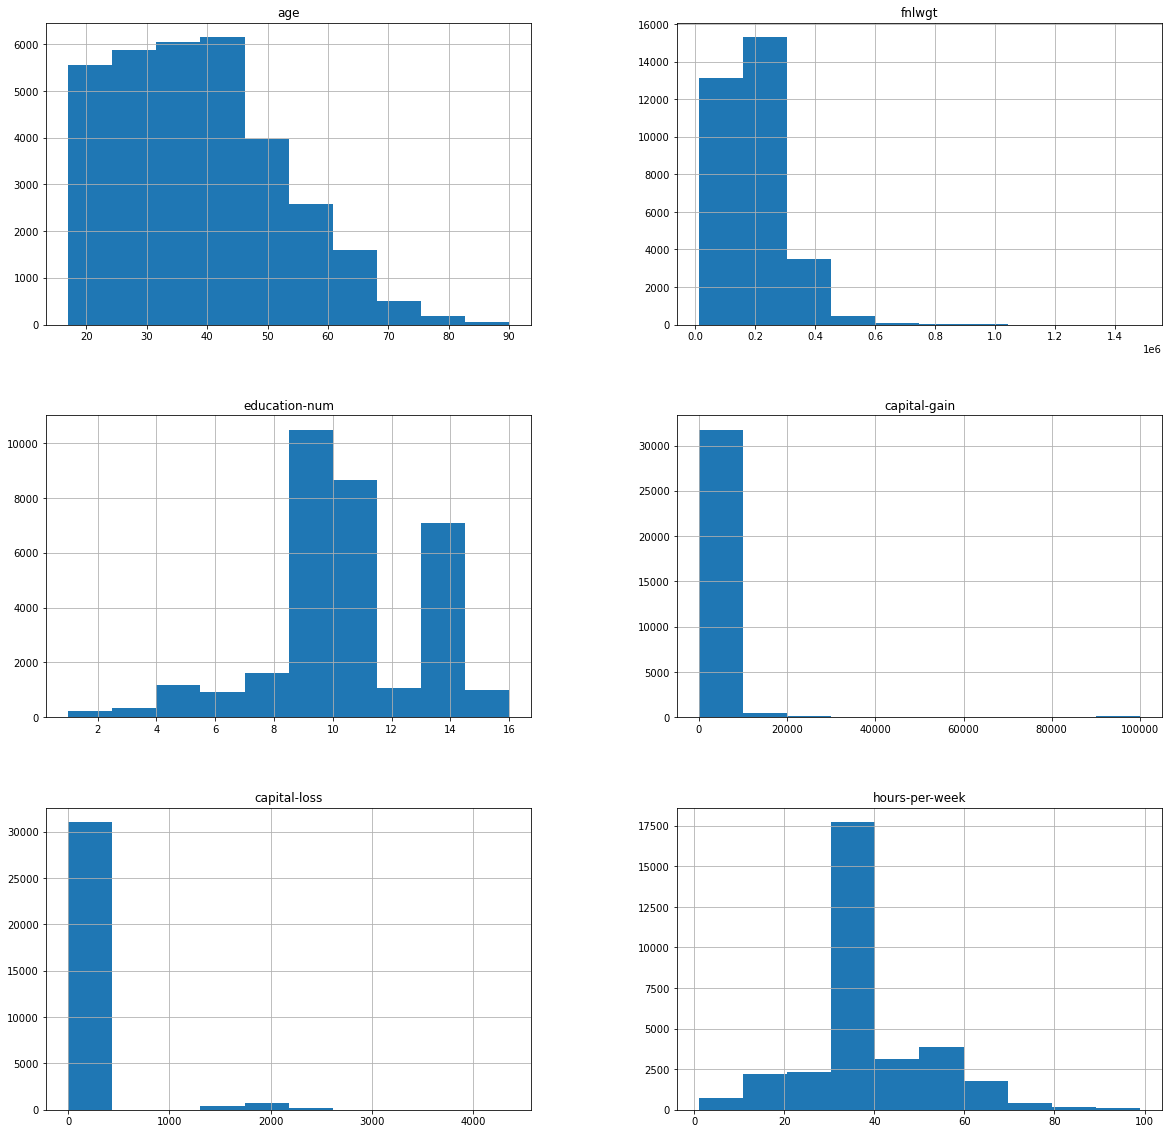

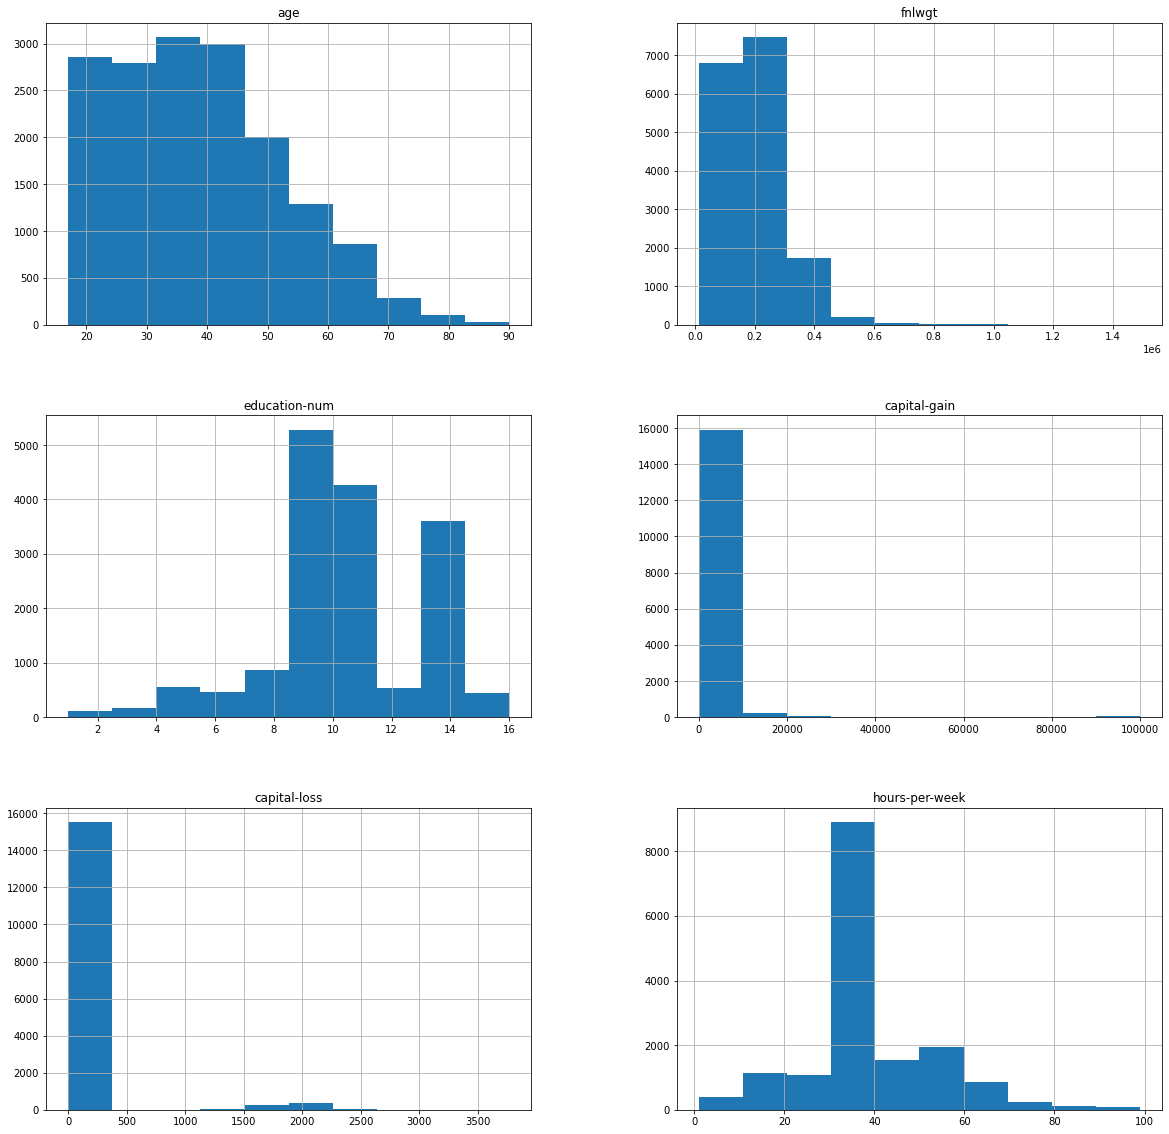

In [13]:
#visualize the dataframes contiuos variables
df.hist(figsize=(20,20))
df_validation.hist(figsize=(20,20))
plt.show()

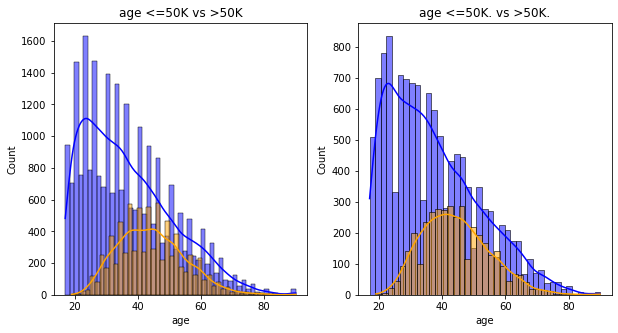

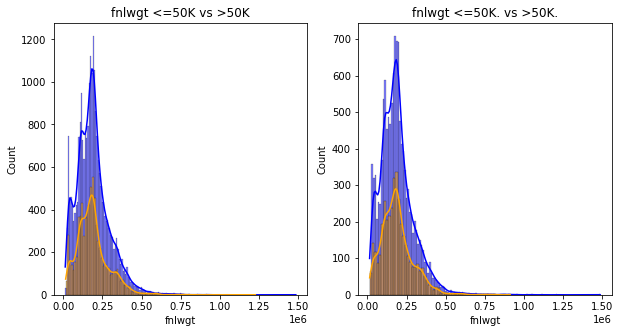

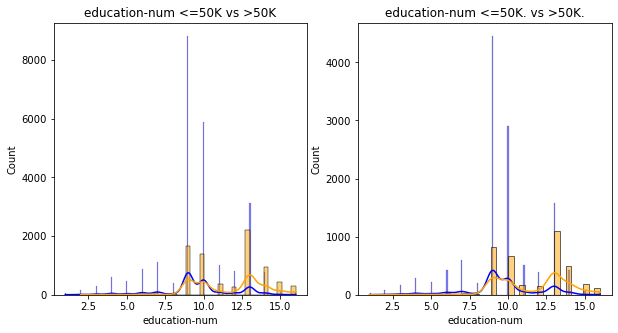

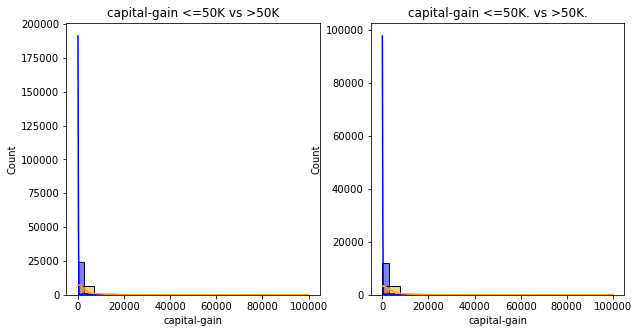

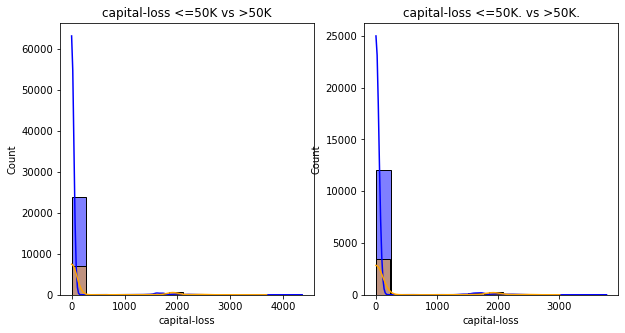

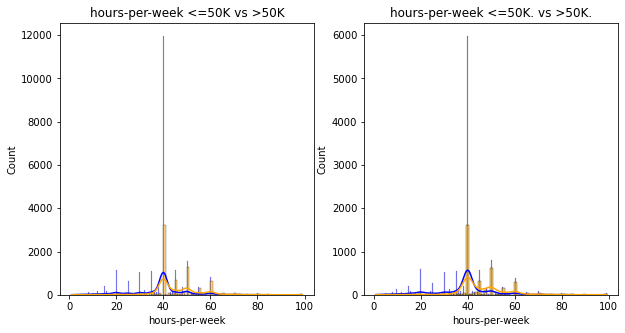

In [14]:
#visualize continuous variables split by income category, side by side plots from dataframes
for i in continuous_variables:
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    #main dataframe on subplot 1
    sns.histplot(df[df['income'] == ' <=50K'][i], ax=ax[0], color='blue', kde=True)
    sns.histplot(df[df['income'] == ' >50K'][i], ax=ax[0], color='orange', kde=True)
    ax[0].set_title(i + ' <=50K vs >50K')
    #validation dataframe on subplot 2
    sns.histplot(df_validation[df_validation['income'] == ' <=50K.'][i], ax=ax[1], color='blue', kde=True)
    sns.histplot(df_validation[df_validation['income'] == ' >50K.'][i], ax=ax[1], color='orange', kde=True)
    ax[1].set_title(i + ' <=50K. vs >50K.')

Since this is census data with pretty normal distributions, outliers will not be treated on the continous data. Outliers are punished harshly with large residual errors. With a relatively small dataset and not a lot of outliers, the model will be able to handle them.

c:\Users\smcgb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\smcgb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\smcgb\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\smcgb\anaconda3\lib\si

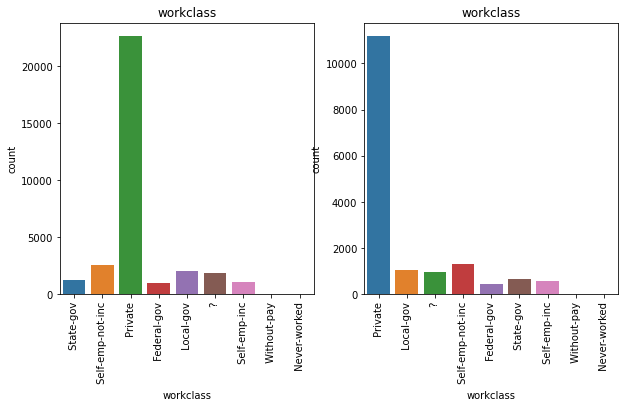

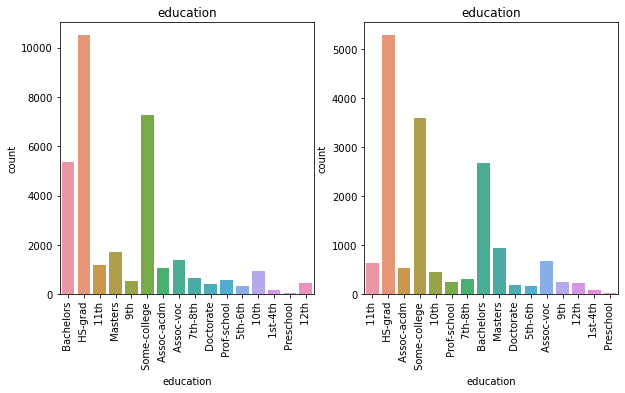

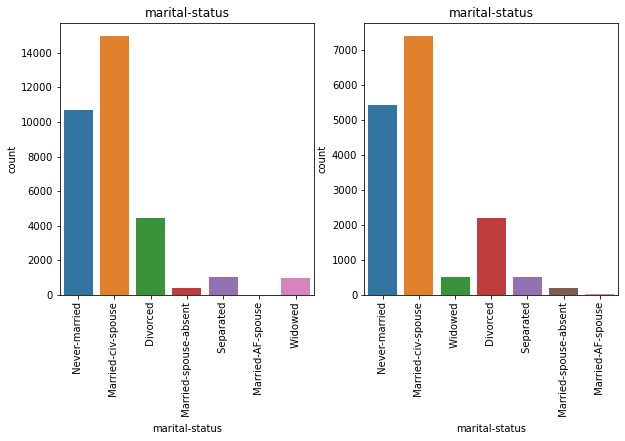

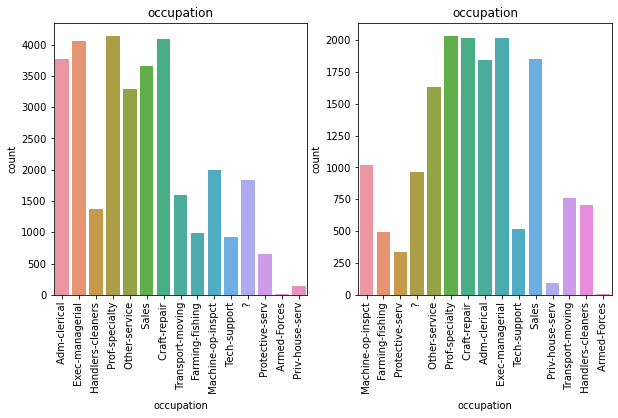

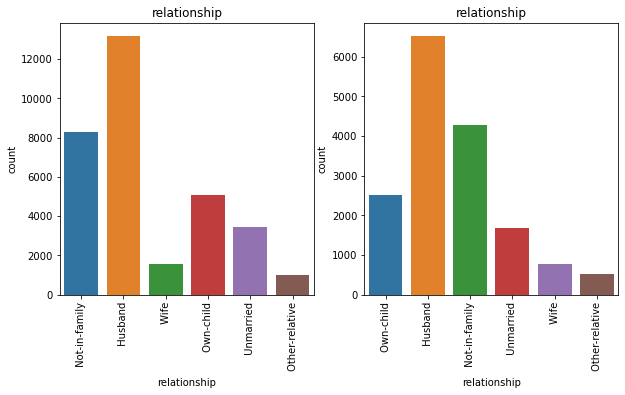

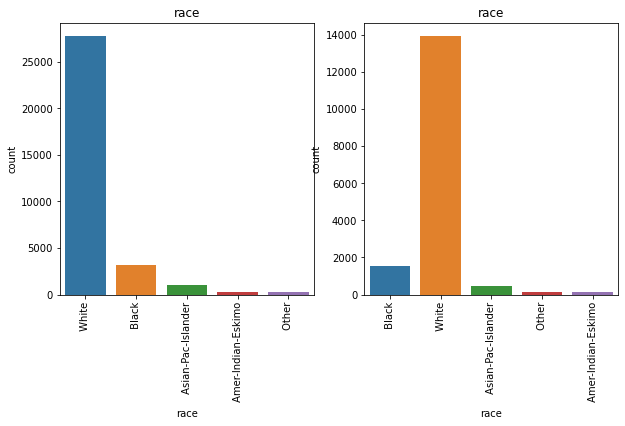

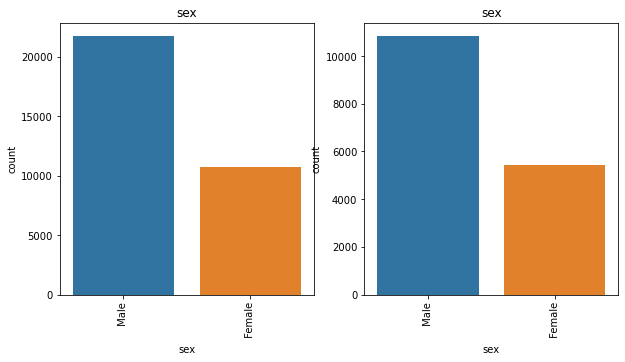

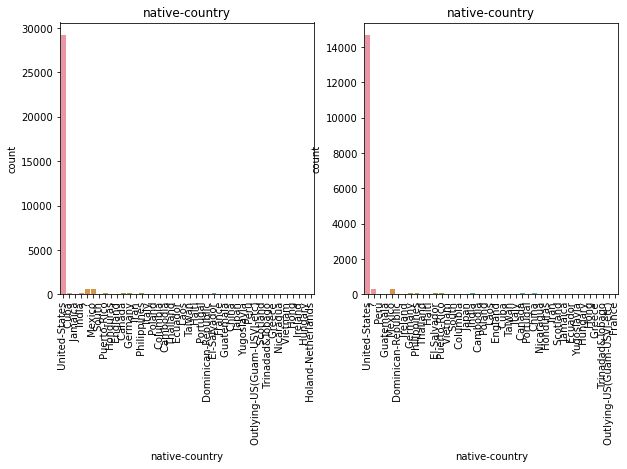

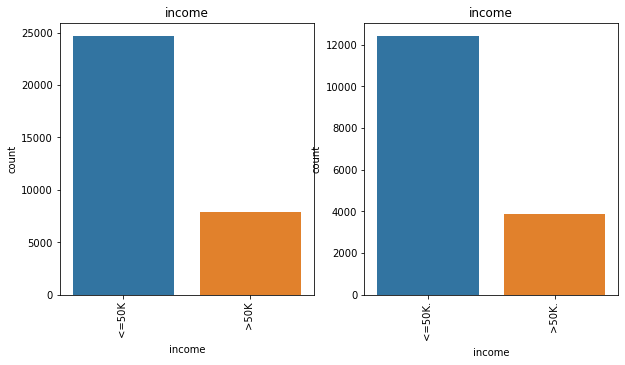

In [15]:
#visualize the dataframes categorical variables
for i in categorical_variables:
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    #main dataframe on subplot 1
    sns.countplot(df[i], ax=ax[0])
    ax[0].set_title(i)
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    #validation dataframe on subplot 2
    sns.countplot(df_validation[i], ax=ax[1])
    ax[1].set_title(i)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

In [16]:
#native country has a lot of categories categories with very few observations. I will explore the values and combine categories with low counts
df['native-country'].value_counts()

 United-States                 29153
 Mexico                          639
 ?                               582
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Japan                            62
 Guatemala                        62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

In [17]:
#view distinct values for native country, 
df['native-country'].unique()

array([' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary', ' Holand-Netherlands'], dtype=object)

In [18]:
#view distinct values for native country in validation dataframe
df_validation['native-country'].unique()

array([' United-States', ' ?', ' Peru', ' Guatemala', ' Mexico',
       ' Dominican-Republic', ' Ireland', ' Germany', ' Philippines',
       ' Thailand', ' Haiti', ' El-Salvador', ' Puerto-Rico', ' Vietnam',
       ' South', ' Columbia', ' Japan', ' India', ' Cambodia', ' Poland',
       ' Laos', ' England', ' Cuba', ' Taiwan', ' Italy', ' Canada',
       ' Portugal', ' China', ' Nicaragua', ' Honduras', ' Iran',
       ' Scotland', ' Jamaica', ' Ecuador', ' Yugoslavia', ' Hungary',
       ' Hong', ' Greece', ' Trinadad&Tobago',
       ' Outlying-US(Guam-USVI-etc)', ' France'], dtype=object)

In [19]:
def country_clean(df): 
    #There is a large category with a ? value. I will replace this with the most common value, United States
    df['native-country'].replace(' ?', ' United-States', inplace=True)
    #Puerto Rico and Outlying-US(Guam-USVI-etc) will be combined with the United States
    df['native-country'].replace(' Puerto-Rico', ' United-States', inplace=True)
    df['native-country'].replace(' Outlying-US(Guam-USVI-etc)', ' United-States', inplace=True)
    #Central american countries will converted to a central-america category
    #note that Mexico will be kept as a separate category due to its large size
    df['native-country'].replace(' Cuba', ' Central-America', inplace=True)
    df['native-country'].replace(' Honduras', ' Central-America', inplace=True)
    df['native-country'].replace(' Guatemala', ' Central-America', inplace=True)
    df['native-country'].replace(' Nicaragua', ' Central-America', inplace=True)
    df['native-country'].replace(' El-Salvador', ' Central-America', inplace=True)
    df['native-country'].replace(' Trinadad&Tobago', ' Central-America', inplace=True)
    #The caribbean islands will be combined with Central America
    df['native-country'].replace(' Cuba', ' Central-America', inplace=True)
    df['native-country'].replace(' Jamaica', ' Central-America', inplace=True)
    df['native-country'].replace(' Dominican-Republic', ' Central-America', inplace=True)
    df['native-country'].replace(' Haiti', ' Central-America', inplace=True)
    df['native-country'].replace(' Trinadad&Tobago', ' Central-America', inplace=True)
    #European countries will be combined into a Europe category
    df['native-country'].replace(' England', ' Europe', inplace=True)
    df['native-country'].replace(' Germany', ' Europe', inplace=True) 
    df['native-country'].replace(' Italy', ' Europe', inplace=True)
    df['native-country'].replace(' Poland', ' Europe', inplace=True)
    df['native-country'].replace(' Portugal', ' Europe', inplace=True)
    df['native-country'].replace(' France', ' Europe', inplace=True)
    df['native-country'].replace(' Yugoslavia', ' Europe', inplace=True)
    df['native-country'].replace(' Greece', ' Europe', inplace=True)
    df['native-country'].replace(' Scotland', ' Europe', inplace=True)
    df['native-country'].replace(' Ireland', ' Europe', inplace=True)
    df['native-country'].replace(' Hungary', ' Europe', inplace=True)
    df['native-country'].replace(' Holand-Netherlands', ' Europe', inplace=True)
    #South American countries will be combined into a South-America category
    df['native-country'].replace(' Columbia', ' South-America', inplace=True)
    df['native-country'].replace(' Peru', ' South-America', inplace=True)
    df['native-country'].replace(' Ecuador', ' South-America', inplace=True)
    df['native-country'].replace(' Venezuela', ' South-America', inplace=True)
    df['native-country'].replace(' Honduras', ' South-America', inplace=True)
    #Africa and Asia will be combined into a AMEA category
    df['native-country'].replace(' Cambodia', ' AMEA', inplace=True)
    df['native-country'].replace(' Thailand', ' AMEA', inplace=True)
    df['native-country'].replace(' Laos', ' AMEA', inplace=True)
    df['native-country'].replace(' Taiwan', ' AMEA', inplace=True)
    df['native-country'].replace(' India', ' AMEA', inplace=True)
    df['native-country'].replace(' China', ' AMEA', inplace=True)
    df['native-country'].replace(' Japan', ' AMEA', inplace=True)
    df['native-country'].replace(' Iran', ' AMEA', inplace=True)
    df['native-country'].replace(' Hong', ' AMEA', inplace=True)
    df['native-country'].replace(' Philippines', ' AMEA', inplace=True)
    df['native-country'].replace(' Vietnam', ' AMEA', inplace=True)
    df['native-country'].replace(' Hong', ' AMEA', inplace=True)
    # note that South here is not explicit to what country. It could be South Korea or South Africa. I will assume South Korea and combine with AMEA
    df['native-country'].replace(' South', ' AMEA', inplace=True)



In [20]:
#call the function to clean the native country column
country_clean(df)
country_clean(df_validation)
#view new values for native country
df['native-country'].unique(), df_validation['native-country'].unique()

(array([' United-States', ' Central-America', ' AMEA', ' Mexico',
        ' Europe', ' Canada', ' South-America'], dtype=object),
 array([' United-States', ' South-America', ' Central-America', ' Mexico',
        ' Europe', ' AMEA', ' Canada'], dtype=object))

In [21]:
df['native-country'].value_counts()

 United-States      29863
 AMEA                 751
 Mexico               639
 Central-America      524
 Europe               521
 Canada               121
 South-America        118
Name: native-country, dtype: int64

In [22]:
df_validation['native-country'].value_counts()

 United-States      15010
 AMEA                 345
 Mexico               308
 Europe               259
 Central-America      235
 Canada                61
 South-America         58
Name: native-country, dtype: int64

The visual

In [23]:
#drop fnlwgt column, this column represents a weight variable that is not needed for this analysis as XGBoost is a tree based model and creates its own weights
df.drop('fnlwgt', axis=1, inplace=True)
df_validation.drop('fnlwgt', axis=1, inplace=True)

<AxesSubplot:xlabel='native-country', ylabel='Count'>

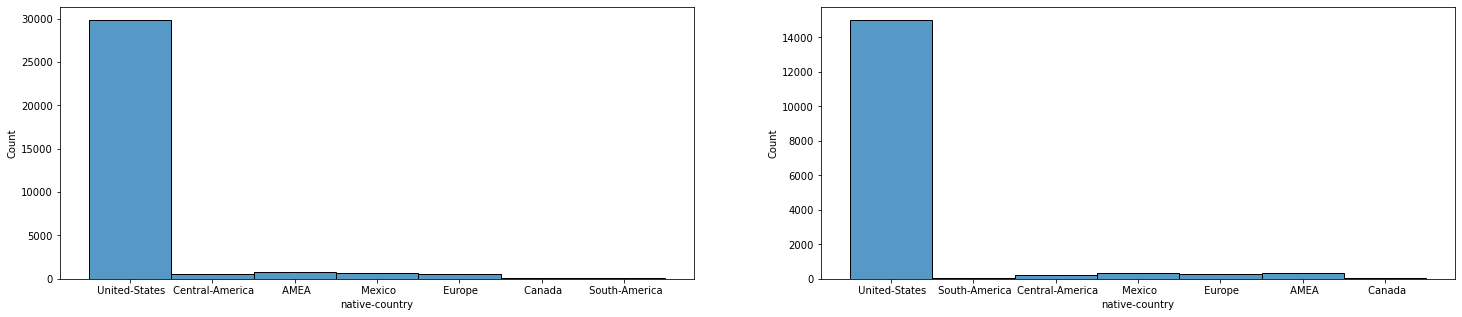

In [24]:
#plot the native country column for each dataframe in a subplot
fig, ax = plt.subplots(1,2, figsize=(25,5))
sns.histplot(df['native-country'], ax=ax[0])
sns.histplot(df_validation['native-country'], ax=ax[1])


In [25]:
#It seems education-num and education are the same. I will test this by comparing the values
df['education-num'].value_counts(), df['education'].value_counts()

(9     10494
 10     7282
 13     5353
 14     1722
 11     1382
 7      1175
 12     1067
 6       933
 4       645
 15      576
 5       514
 8       433
 16      413
 3       332
 2       166
 1        50
 Name: education-num, dtype: int64,
  HS-grad         10494
  Some-college     7282
  Bachelors        5353
  Masters          1722
  Assoc-voc        1382
  11th             1175
  Assoc-acdm       1067
  10th              933
  7th-8th           645
  Prof-school       576
  9th               514
  12th              433
  Doctorate         413
  5th-6th           332
  1st-4th           166
  Preschool          50
 Name: education, dtype: int64)

In [26]:
#According to the print and the data dictionary, education-num and education are the same. I will drop education and keep the education-num column for each dataframe
df.drop('education', axis=1, inplace=True)
df_validation.drop('education', axis=1, inplace=True)
df.columns, df_validation.columns

(Index(['age', 'workclass', 'education-num', 'marital-status', 'occupation',
        'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
        'hours-per-week', 'native-country', 'income'],
       dtype='object'),
 Index(['age', 'workclass', 'education-num', 'marital-status', 'occupation',
        'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
        'hours-per-week', 'native-country', 'income'],
       dtype='object'))

In [27]:
#Income is the target variable. I will convert the values to 0 and 1 for each dataframe
df['income'].replace(' <=50K', 0, inplace=True)
df['income'].replace(' >50K', 1, inplace=True)
df_validation['income'].replace(' <=50K.', 0, inplace=True)
df_validation['income'].replace(' >50K.', 1, inplace=True)

In [28]:
#convert all object columns to category columns
df[['workclass','marital-status','occupation','relationship','race','sex','native-country']] = df[['workclass','marital-status','occupation','relationship','race','sex','native-country']].astype('category')
df_validation[['workclass','marital-status','occupation','relationship','race','sex','native-country']] = df[['workclass','marital-status','occupation','relationship','race','sex','native-country']].astype('category')
df.dtypes == df_validation.dtypes

age               True
workclass         True
education-num     True
marital-status    True
occupation        True
relationship      True
race              True
sex               True
capital-gain      True
capital-loss      True
hours-per-week    True
native-country    True
income            True
dtype: bool

In [29]:
#one hot encode the categorical columns using pandas get_dummies function
df = pd.get_dummies(df)
df_validation = pd.get_dummies(df_validation)
df.columns == df_validation.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [30]:
df.columns

Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'income', 'workclass_ ?', 'workclass_ Federal-gov',
       'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay',
       'marital-status_ Divorced', 'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-spouse-absent',
       'marital-status_ Never-married', 'marital-status_ Separated',
       'marital-status_ Widowed', 'occupation_ ?', 'occupation_ Adm-clerical',
       'occupation_ Armed-Forces', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Farming-fishing',
       'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct',
       'occupation_ Other-service', 'occupation_ Priv-house-serv',
       'occupation_ Prof-specialty', 'occupation_ Protective-serv',
     

#### Data Cleaning

Data has been cleaned and prepared for the model. The steps taken are as follows:

1. The data main data and validation data was converted to a CSV file.
2. The data was read into a dataframe.
3. Summary Statistics were calculated for the data.
4. Data was visualized to identify outliers. No outliers were treated due to the data being census data with normal distributions and valid.
5. Category counts were calculated for the categorical data.
6. Native country category was reduced to combine smaller categories into a singular larger categories
7. Weights column was dropped because xgboost has a built in weight parameter.
8. Education was simplified to only have the education-num column instead of the categorical education column
9. Datatypes were converted to category for categorical data
10. Categorical data was encoded using one-hot encoding

#### Splitting the Data

The data will be split on the adult data read in as `df`. The data will be split by, instead of the usual 80% of the set that it is in, as 80% the size of the validation data. This will help prevent overfitting as well as reduce the computational cost.

In [31]:
(len(df_validation) * .8) / len(df)

0.40018440544610756

In [32]:
#splt the data using test train split, train size will be 80% of the validation data, or 40% of the original data
X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=.6, random_state=42)

In [38]:
#split validation into target and inputs

X_val = df_validation.drop('income', axis=1)
y_val = df_validation['income']

In [39]:
#export the test train and validation data to csv files
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
# validation to csv
X_val.to_csv('X_val.csv', index=False)
y_val.to_csv('y_val.csv', index=False)

In [33]:
# verify the split
len(X_train), len(X_test), len(y_train), len(y_test)

(13014, 19523, 13014, 19523)

## XGBoost Model

The XGBoost model will be built using the XGBoost library in Python. The model will be built using the following parameters:


In [34]:
# instantiate xgb classifier

xgb_clf = xgb.XGBClassifier()
# fit the model
fit = xgb_clf.fit(X_train, y_train)

#predict the model
y_pred = xgb_clf.predict(X_test)



In [62]:
#import evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

#evaluate the model
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification Report: \n', classification_report(y_test, y_pred))

Accuracy:  0.8660554218101726
Precision:  0.7606942067954046
Recall:  0.6554338668913227
F1:  0.7041520533997059
ROC AUC:  0.7945866457976072
Confusion Matrix: 
 [[13796   979]
 [ 1636  3112]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     14775
           1       0.76      0.66      0.70      4748

    accuracy                           0.87     19523
   macro avg       0.83      0.79      0.81     19523
weighted avg       0.86      0.87      0.86     19523



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

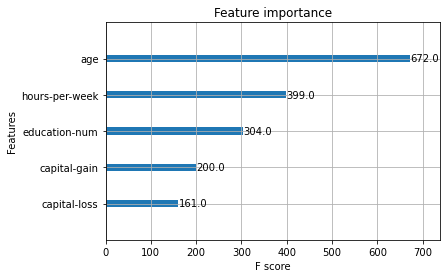

In [44]:
#plot top 5 features
xgb.plot_importance(xgb_clf, max_num_features=5)

There is a lot of hyperparameter tuning that can be done with XGBoost, but without that we are hitting an 86% accuracy. This is way higher than the target. I will now verify the model on the validation data.

In [41]:
val_pred = xgb_clf.predict(X_val)

In [48]:
#evaluate the model
print('Accuracy: ', accuracy_score(y_val, val_pred))
print('Precision: ', precision_score(y_val, val_pred))
print('Recall: ', recall_score(y_val, val_pred))
print('F1: ', f1_score(y_val, val_pred))
print('ROC AUC: ', roc_auc_score(y_val, val_pred))
print('Confusion Matrix: \n', confusion_matrix(y_val, val_pred))
print('Classification Report: \n', classification_report(y_val, val_pred))

Accuracy:  0.7974318014254117
Precision:  0.6070175438596491
Recall:  0.4048361934477379
F1:  0.4857276555919513
ROC AUC:  0.6618710331679558
Confusion Matrix: 
 [[11422  1008]
 [ 2289  1557]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.92      0.87     12430
           1       0.61      0.40      0.49      3846

    accuracy                           0.80     16276
   macro avg       0.72      0.66      0.68     16276
weighted avg       0.78      0.80      0.78     16276



The model performs worse on the validation data by 6% total points. This is a good sign that the model is not overfitting. The model could be put into production for use in targeting individuals for donations. The model can also be improved via hyper parameter tuning. Let's see how the model performs on the test data after hyper parameter tuning.

In [49]:
# import gridsearchcv
from sklearn.model_selection import GridSearchCV

# define the grid of hyperparameters
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

In [50]:
# instantiate the gridsearchcv

grid = GridSearchCV(xgb_clf, parameters, n_jobs=4, verbose=3, scoring='neg_log_loss', cv=5)

In [51]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 3840 candidates, totalling 19200 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_ca...
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, predictor='auto',
                                     rand

In [52]:
#instantiate the best model
best_xgb_clf = grid.best_estimator_

In [53]:
#predict test data
y_tuned_pred = best_xgb_clf.predict(X_test)

In [54]:
#evaluate the model
print('Accuracy: ', accuracy_score(y_test, y_tuned_pred))
print('Precision: ', precision_score(y_test, y_tuned_pred))
print('Recall: ', recall_score(y_test, y_tuned_pred))
print('F1: ', f1_score(y_test, y_tuned_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_tuned_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_tuned_pred))
print('Classification Report: \n', classification_report(y_test, y_tuned_pred))

Accuracy:  0.8687189468831634
Precision:  0.7749811225773975
Recall:  0.6484835720303286
F1:  0.7061116844398578
ROC AUC:  0.7939879789085653
Confusion Matrix: 
 [[13881   894]
 [ 1669  3079]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.94      0.92     14775
           1       0.77      0.65      0.71      4748

    accuracy                           0.87     19523
   macro avg       0.83      0.79      0.81     19523
weighted avg       0.86      0.87      0.86     19523



The tuned model did not improve on the testing data. I will now checking the validation data to see if the model is overfitting.

In [55]:
y_best_val_pred = best_xgb_clf.predict(X_val)

In [56]:
#evaluate the model
print('Accuracy: ', accuracy_score(y_val, y_best_val_pred))
print('Precision: ', precision_score(y_val, y_best_val_pred))
print('Recall: ', recall_score(y_val, y_best_val_pred))
print('F1: ', f1_score(y_val, y_best_val_pred))
print('ROC AUC: ', roc_auc_score(y_val, y_best_val_pred))
print('Confusion Matrix: \n', confusion_matrix(y_val, y_best_val_pred))
print('Classification Report: \n', classification_report(y_val, y_best_val_pred))

Accuracy:  0.8003809289751782
Precision:  0.6206060606060606
Recall:  0.3993759750390016
F1:  0.48599905078310396
ROC AUC:  0.6619164670046175
Confusion Matrix: 
 [[11491   939]
 [ 2310  1536]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.92      0.88     12430
           1       0.62      0.40      0.49      3846

    accuracy                           0.80     16276
   macro avg       0.73      0.66      0.68     16276
weighted avg       0.78      0.80      0.78     16276



In [63]:
# Dump model to pickle file and raw text file
import pickle
pickle.dump(best_xgb_clf, open('best_xgb_clf.pkl', 'wb'))

## Data Summary and Conclusion

This model exceeds the target accuracy score on training data by 16% and on testing data by 10%, ensuring a great fit for production usage. I highly recommend using this model to start targetting donors. In future states, if XGBoost is to be reran on another sample with the same features, I do not recommend using hyper paramter tuning. There was not much benefit to paramter tuning and the computation cost was high on specialized CUDA hardware that handles the model well.

The model may be made computationally less expensive by reducing the training set even further. With a 70% target accuracy, the model could likely be reduced by a large amount. Another approach would be to compare this model to an easier to explain decision tree. The decision tree would be easier to explain to the business but would not be as accurate. The decision tree would be a good starting point for the business to understand the data and then use the XGBoost model to target donors.

The final recommendation would be to collect actual donation amounts and use a traditional or XGBoost Regressor model to predict likely donors and their donation amounts. This would be a great way to make financial decisions on who to target for donations in the future.

## Sources

Becker, B., &amp; Kohavi, R. (n.d.).  Census Income Data Set. UCI Machine Learning Repository: Census Income Data Set. Retrieved October 24, 2022, from https://archive.ics.uci.edu/ml/datasets/Census+Income 

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Kohavi, R. (1996). Scaling up the accuracy of Naive-Bayes classifiers: A decision-tree hybrid. Retrieved October 24, 2022, from https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf 

Starmer, J. (2019, October 24). XGBoost: A Scalable Tree Boosting System. Retrieved October 24, 2022, from https://www.youtube.com/watch?v=8b1JEDvenQU



